In [1]:
import gtd_funcs as f # file with custom functions

import numpy as np # data manipulation / transformations
import matplotlib.pyplot as plt # plotting
%matplotlib inline 

from collections import defaultdict # dict with default val, used for top counts below
import pickle # saving/loading
import datetime # date handling/timing
import pandas as pd # data manipulation/storing

/home/joey/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/joey/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/joey/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module 

In [108]:
df = f.load_plus_dates('data/globalterrorismdb_0617.csv')

/home/joey/anaconda2/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


df preprocess shape: (170350, 135)
df postprocess shape: (170350, 137)
unique event ids == to row count? True


### using a previously hand-generated csv file

- csv used in conjunction with GTD codebook, contains all available features
- hand labeled 'useful' features
- below reading sheet in, going through each feat in dataframe, sorting into feat categories


In [109]:
var_list = f.get_vars('data/gtd_feats.csv')

# splitting feats into lists by type
cats = []
txts = []
dums = []
quants = []
total = 0
for index, row in var_list.iterrows():
    
#     print type(row['useful'])
#     print row['useful'], '..........', row['NAME']
    if row['useful'] == 'y':
        total += 1
        if row['type'] == 'txt':
            txts.append(row['NAME'])
        elif row['type'] == 'dummy':
            dums.append(row['NAME'])
        elif row['type'] == 'cat':
            cats.append(row['NAME'])
        elif row['type'] == 'quant':
            quants.append(row['NAME'])
        elif row['type'] == 'date':
            cats.append(row['NAME'])
        else:
            print 'var not included: {}'.format(row['NAME'])
#         print row['NAME'], row['type']
#         print row['type']



var not included: date_obj


In [110]:
print 'len of-- df: {}. txts: {}, quants: {}, dums: {}, cats: {}, total: {}'.format(
        df.shape[1],len(txts), len(quants), len(dums), len(cats), total)

len of-- df: 137. txts: 18, quants: 13, dums: 14, cats: 13, total: 59


In [111]:
for cat in cats:
    f.feat_desc(df,cat)
    print '-'*40

feat : country_txt
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 205
----------------------------------------
feat : region_txt
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 12
----------------------------------------
feat : provstate
na sum: 14502 and pct: 8.51306134429
unknown sum: 0 and pct: 0.0
number unique: 2494
----------------------------------------
feat : city
na sum: 446 and pct: 0.261813912533
unknown sum: 0 and pct: 0.0
number unique: 33957
----------------------------------------
feat : alternative_txt
na sum: 143719 and pct: 84.3668916936
unknown sum: 0 and pct: 0.0
number unique: 5
----------------------------------------
feat : attacktype1_txt
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 9
----------------------------------------
feat : targtype1_txt
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 22
----------------------------------------
feat : targsubtype1_txt
na sum: 9345 and pct: 5.485

### categorical feats initial reaction:

- majority of cat feats have all or high majority of observations recorded as non-null values, 
- provstate ~ 8.5% msising is discouraging as city is > 99% non-null
    - can fill in later or disregard as other location data is available (emphasis on country)
- alternative_txt ~ 85% missing could mean majority of events are not in doubt of being terroristic
- targsubtype1_txt could be useful for modeling, will handle later on 
    - same with weapsubtype1_txt
- claim mode ~ 90% missing signifies most attacks are not claimed by an organization
    - this could mean some gname (organization) designations might be misleading
- no cat feats in use have unknown values (-9 or -99)


In [112]:
for dum in dums:
    f.feat_desc(df,dum)
    print '-'*40

feat : extended
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2
----------------------------------------
feat : crit1
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2
----------------------------------------
feat : crit2
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2
----------------------------------------
feat : crit3
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2
----------------------------------------
feat : doubtterr
na sum: 0 and pct: 0.0
unknown sum: 13786 and pct: 8.09275022014
number unique: 3
----------------------------------------
feat : multiple
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2
----------------------------------------
feat : success
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2
----------------------------------------
feat : suicide
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 2
-------------------------------------

### dummy feats initial reaction:

- doubtterr close to 10% unknown
- claimed ~40% missing or unknown
- most events don't have competing claims of responsibility
    - can look into events with multiple claims
- property ~11% unknown
    - possibly due to minimal information/lack of first hand accounts
    - likewise with ransom (~55% missing)



In [113]:
for quant in quants:
    f.feat_desc(df,quant,quant=1)
    print '-'*40

feat : nperps
na sum: 71124 and pct: 41.7516877018
unknown sum: 73053 and pct: 42.8840622248
----------------------------------------
feat : nperpcap
na sum: 69499 and pct: 40.7977692985
unknown sum: 1646 and pct: 0.966245964191
----------------------------------------
feat : nkill
na sum: 9682 and pct: 5.68359260346
unknown sum: 0 and pct: 0.0
----------------------------------------
feat : nkillter
na sum: 66663 and pct: 39.1329615498
unknown sum: 0 and pct: 0.0
----------------------------------------
feat : nwound
na sum: 15325 and pct: 8.99618432639
unknown sum: 0 and pct: 0.0
----------------------------------------
feat : nwoundte
na sum: 68749 and pct: 40.3574992662
unknown sum: 0 and pct: 0.0
----------------------------------------
feat : propvalue
na sum: 134863 and pct: 79.1681831523
unknown sum: 25139 and pct: 14.7572644555
----------------------------------------
feat : nhostkid
na sum: 157858 and pct: 92.6668623422
unknown sum: 1134 and pct: 0.665688288817
--------------

### quant feats initial reaction:

- much higher degree of null values, especially on significant details of events
    - nperps, propvalue, nhours, ndays, ransomamt/paid, hostage data > ~83% missing or unknown
- may hamper ability to model/get a clear picture of organizations' operating characteristics

    


In [115]:
# converting unknown values (-9, -99) into NaN
na_vals = [-9,-99]
for col in df.columns:
    df[col].replace(na_vals,np.nan,inplace=True)

In [344]:
# converting NaNs on dummys into 0 -- treating as not observed
for col in dums:
    df[col].replace(np.nan,0,inplace=True)

In [116]:
feats_using = [
    'country_txt',
    'region_txt',
    'city',
    'attacktype1_txt',
    'targtype1_txt',
    'targsubtype1_txt',
    'natlty1_txt',
    'weaptype1_txt',
    'weekday',
    'extended',
    'crit1',
    'crit2',
    'crit3',
    'doubtterr',
    'multiple',
    'success',
    'suicide',
    'individual',
    'claimed',
    'property',
    'ishostkid',
    'ransom',
    'nperps',
    'nperpcap',
    'nkill',
    'nkillter',
    'nwound',
    'nwoundte',
    'target1',
    'weapdetail',
    'gname',
    'iyear',
    'imonth',
    'iday'
#     'propvalue',
#     ''

]

print 'number of feats using: {}, number of total feats: {}'.format(len(feats_using), df.shape[1])

number of feats using: 34, number of total feats: 137


In [117]:
df2 = df[feats_using+['date_obj','eventid']]
df2.shape, df.shape

((170350, 36), (170350, 137))

In [118]:
for x in df2.columns:
    print x
    

country_txt
region_txt
city
attacktype1_txt
targtype1_txt
targsubtype1_txt
natlty1_txt
weaptype1_txt
weekday
extended
crit1
crit2
crit3
doubtterr
multiple
success
suicide
individual
claimed
property
ishostkid
ransom
nperps
nperpcap
nkill
nkillter
nwound
nwoundte
target1
weapdetail
gname
iyear
imonth
iday
date_obj
eventid


In [119]:
cats_using = []
quants_using = []
dums_using = []
txts_using = []
for x in df2.columns:
    if x in cats:
        cats_using.append(x)
    elif x in quants:
        quants_using.append(x)
    elif x in dums:
        dums_using.append(x)
    elif x in txts:
        txts_using.append(x)
        
print 'number of-- cats: {}, quants: {}, dums: {}, txts: {}'.format(len(cats_using),
                                                                    len(quants_using), 
                                                                    len(dums_using), 
                                                                    len(txts_using))

# above + date_obj == df2.shape

number of-- cats: 9, quants: 6, dums: 13, txts: 4


In [120]:
# DATE VALIDATION
print 'first year: {} and last year: {}'.format(df2['iyear'].min(),df2['iyear'].max())
# print '\n'
print 'min day: {} and max day: {}'.format(df2['iday'].min(), df2['iday'].max())
# print '\n'
print 'min month: {} and max month: {}'.format(df2['imonth'].min(), df2['imonth'].max())

first year: 1970 and last year: 2016
min day: 1 and max day: 31
min month: 1 and max month: 12


# starting eda


### Top values for all events:

In [121]:
for cat in cats_using:
    f.feat_desc(df2,cat)
    f.top_vals(df2,cat,0,3)
    
#     print df2[cat].value_counts()
    
    print '-'*30

feat : country_txt
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 205
value: Iraq has 22,130 count (12.99 %)
value: Pakistan has 13,634 count (8.00 %)
value: Afghanistan has 11,306 count (6.64 %)
------------------------------
feat : region_txt
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 12
value: Middle East & North Africa has 46,511 count (27.30 %)
value: South Asia has 41,497 count (24.36 %)
value: South America has 18,762 count (11.01 %)
------------------------------
feat : city
na sum: 446 and pct: 0.261813912533
unknown sum: 0 and pct: 0.0
number unique: 33957
value: Unknown has 9,162 count (5.38 %)
value: Baghdad has 7,206 count (4.23 %)
value: Karachi has 2,609 count (1.53 %)
------------------------------
feat : attacktype1_txt
na sum: 0 and pct: 0.0
unknown sum: 0 and pct: 0.0
number unique: 9
value: Bombing/Explosion has 83,073 count (48.77 %)
value: Armed Assault has 40,223 count (23.61 %)
value: Assassination has 18,402 count (10.8

### categorical feat notes:

- terrorism occured in 205 countries between 1970 - 2016 (195 total countries as of 2019 although figure changes over time)
    - 13% in Iraq, 8% Pakistan, 6.64% Afghanistan
- big concentration in regions- ME/North Africa and South Asia account for over 50%
- terrorism occured in 33,957 unique cities (could be error on duplicates),
    - Besides Unknown, Baghdad (4.23%) and Karachi (1.53%) lead (interested in seeing next few vals)
    - Kind of discouraging that city is not observed in ~5.4% of events
- ~13% attacking Iraqis, ~8 Pakistanis (both roughly matching country data), but 6.52% targeting India
- nearly 50% of attacks happen via bombing/explosions, nearly 25% armed assault
- roughly a quarter of attacks target private citizens/property, ~30% target military or police
- weekday choosen for attack look roughly even, no preference



In [122]:
for quant in quants_using:
    print quant
    print df2[quant].describe()
    print '-'*30

nperps
count    26173.000000
mean        33.969778
std        429.024889
min          0.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      25000.000000
Name: nperps, dtype: float64
------------------------------
nperpcap
count    99205.000000
mean         0.132110
std          2.191688
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        406.000000
Name: nperpcap, dtype: float64
------------------------------
nkill
count    160668.000000
mean          2.387246
std          11.327709
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        1500.000000
Name: nkill, dtype: float64
------------------------------
nkillter
count    103687.000000
mean          0.478864
std           4.190902
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         500.000000
Name: nkillter, dtype: float64
------------------------------
nwound

### quant notes:

- max nperps is 25,000 (??)
- max nperpcap == 406
- max nkill 1,500
- max nkillterr is 500
- 7,366 highest nwound
    

## charting

In [123]:
attack_groups = df2.groupby(['attacktype1_txt'])
len(attack_groups)

9

In [124]:
# creating groups by year:
year_groups = df2.groupby(['iyear'])

In [345]:
nuniques = [
    'eventid','country_txt','region_txt','city','natlty1_txt'
#     'country_txt','region_txt','city','attacktype1_txt',
]
print len(nuniques)

5


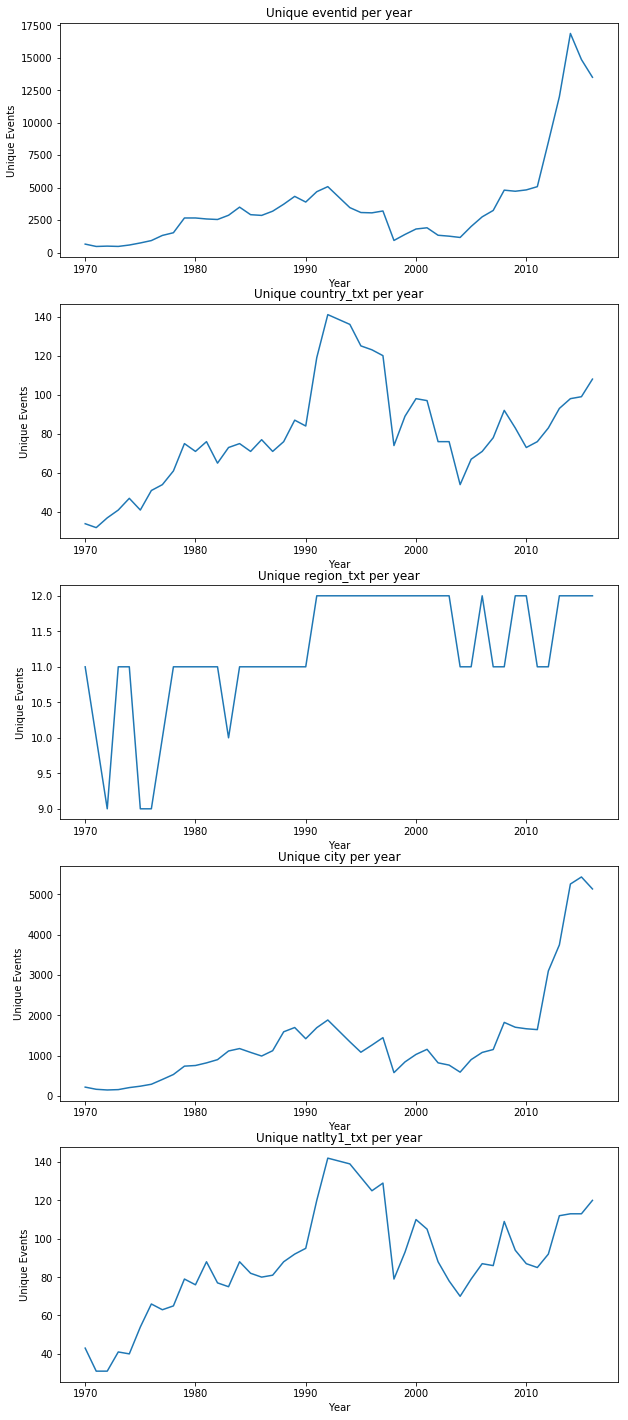

In [126]:
fig, ax = plt.subplots(ncols=1,nrows=len(nuniques), figsize=(10,len(nuniques)*5))

for idx, nunique in enumerate(nuniques):
    year_groups[nunique].nunique().plot(ax=ax[idx])
    ax[idx].set_title('Unique {} per year'.format(nunique))
    ax[idx].set_ylabel('Unique Events')
    ax[idx].set_xlabel('Year')
    

Terrorism events have spiked considerably since just after 2010, as have cities in which events occur. Countries and nationalities targeted peaked in the mid 1990s but (like most event characteristics) are trending up.

In [127]:
quant_charts = ['nkill','nwound']
dum_charts = ['success','suicide','crit1','crit2','crit3']

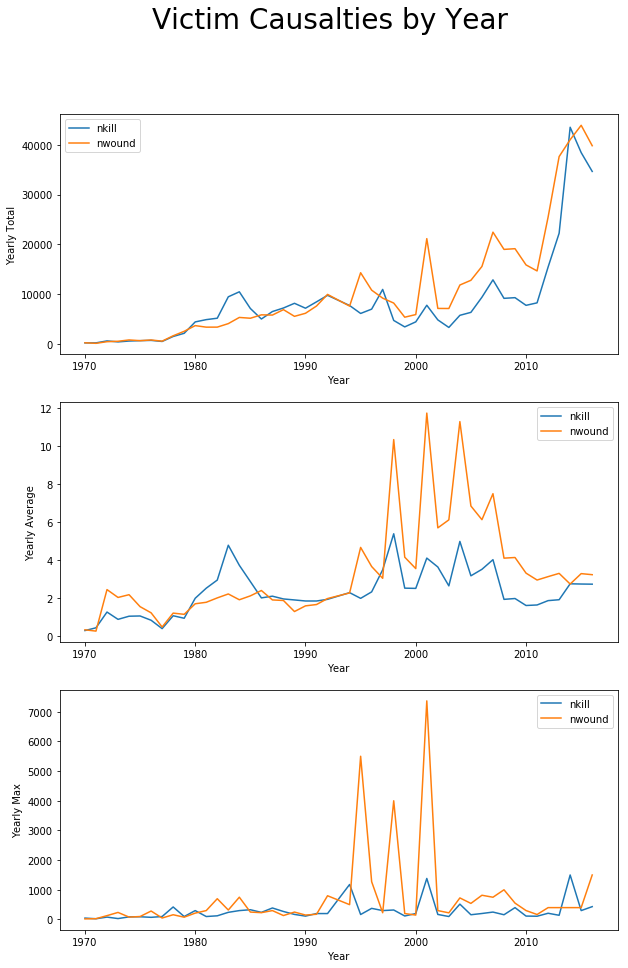

In [128]:
fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(10,15))
# fig.tight_layout()
plt.suptitle('Victim Casualties by Year',fontsize=28)

year_groups['nkill','nwound'].sum().plot(ax=ax[0])
year_groups['nkill','nwound'].mean().plot(ax=ax[1])
year_groups['nkill','nwound'].max().plot(ax=ax[2])
ax[0].set_ylabel('Yearly Total')
ax[0].set_xlabel('Year')
ax[1].set_ylabel('Yearly Average')
ax[1].set_xlabel('Year')
ax[2].set_ylabel('Yearly Max')
ax[2].set_xlabel('Year')
# ax[0].legend()
plt.show()

- Number of casualities per year has increased greatly over previous 10 years
- Average and max wounds spiked in the late 1990s/2000s (possibly due to smaller sample size)

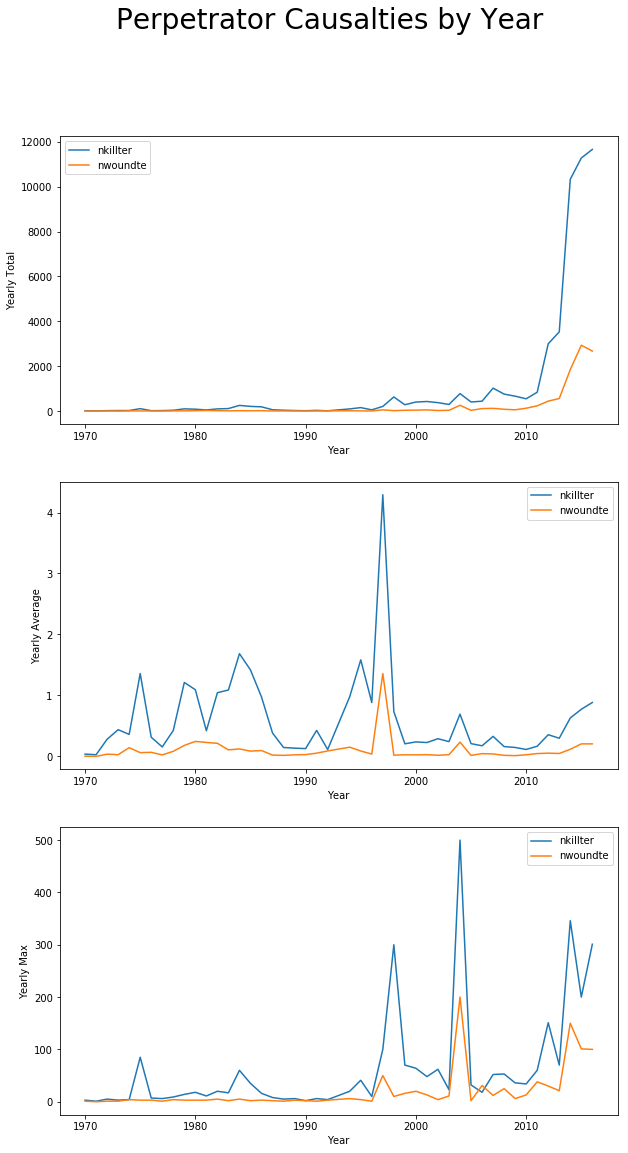

In [129]:
fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(10,18))
# fig.tight_layout()
plt.suptitle('Perpetrator Casualties by Year',fontsize=28)

year_groups['nkillter','nwoundte'].sum().plot(ax=ax[0])
year_groups['nkillter','nwoundte'].mean().plot(ax=ax[1])
year_groups['nkillter','nwoundte'].max().plot(ax=ax[2])
ax[0].set_ylabel('Yearly Total')
ax[0].set_xlabel('Year')
ax[1].set_ylabel('Yearly Average')
ax[1].set_xlabel('Year')
ax[2].set_ylabel('Yearly Max')
ax[2].set_xlabel('Year')
# ax[0].legend()
plt.show()

- Numer of perpetrator casualties has spiked greatly since 2010
    - Max casualties have been increasing drastically recently although below highs seen around 2005
- Perpetrator kills generally at higher levels than wounds
    - Possibly due to unwillingness to surrender or due to reporting errors/uncertainties

### Select dummy feature charts

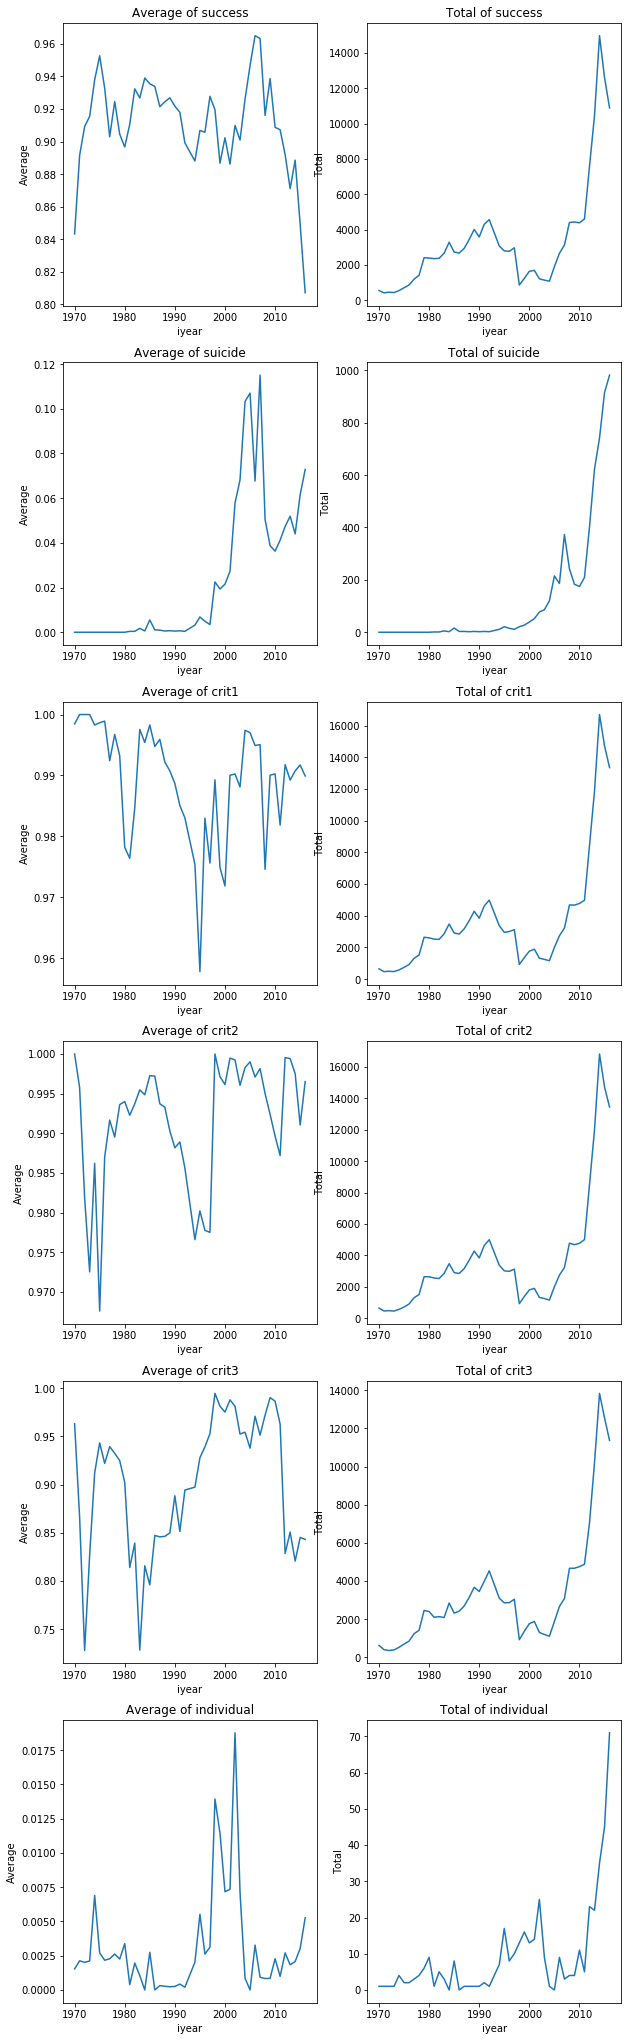

In [130]:
dum_charts = ['success','suicide','crit1','crit2','crit3','individual']
fig, ax = plt.subplots(ncols=2,nrows=len(dum_charts),figsize=(10,20))
# plt.suptitle('Dummy Features by Year',fontsize=25,va='top')
# plt.tight_layout()
for idx, dum in enumerate(dum_charts):
    year_groups[dum].mean().plot(ax=ax[idx,0])
    year_groups[dum].sum().plot(ax=ax[idx,1])
for idx, dum in enumerate(dum_charts):
    ax[idx,0].set_title('Average of {}'.format(dum))
    ax[idx,1].set_title('Total of {}'.format(dum))
    ax[idx,0].set_ylabel('Average')
    ax[idx,1].set_ylabel('Total')
    ax[idx,0].set_xlabel('iyear')
    ax[idx,1].set_xlabel('iyear')
plt.subplots_adjust(top=1.5)
plt.show()

- Number of successful attacks on uprise but at all time low as percentage of total attacks (~80%)
    - Successful attack defined in codebook as 'attack type took place' not whether goals of attack succeeded
- Suicide attacks as a total are at all time highs, have grown exponentially since ~2000
    - Only ~7.5% of total attacks, peaked at ~11% in mid 2000s
- Crit1 (political, economic, religious, social criteria), crit2 (intention to coerce/intimidate), and crit3 (attack outside of international humanitarian laws) all near all time highs
    - Looks like crit3 may be correlated with war in Middle East (where majority of attacks occur)
- Number of 'individual' (perpetrator(s) not affiliated with larger organization) attacks at all time high, although in relation to total attacks well below peaks reached in early 2000s

## top casualties* caused:

#### * casuality defined as killed or wounded

In [131]:
f.casualties_by_x(df2,'gname',20)

Total has 879,671.0 causalties: 383,554.0 deaths (43.60%) and 496,117.0 wounds (56.40%)
------------------------------
Unknown has caused 314,319 casualties: 109,347 deaths (34.79%) and 204,972 wounds (65.21%)
------------------------------
Islamic State of Iraq and the Levant (ISIL) has caused 57,366 casualties: 30,889 deaths (53.85%) and 26,477 wounds (46.15%)
------------------------------
Taliban has caused 48,430 casualties: 24,482 deaths (50.55%) and 23,948 wounds (49.45%)
------------------------------
Boko Haram has caused 26,979 casualties: 18,542 deaths (68.73%) and 8,437 wounds (31.27%)
------------------------------
Al-Qaida has caused 23,887 casualties: 3,610 deaths (15.11%) and 20,277 wounds (84.89%)
------------------------------
Liberation Tigers of Tamil Eelam (LTTE) has caused 22,019 casualties: 10,988 deaths (49.90%) and 11,031 wounds (50.10%)
------------------------------
Al-Qaida in Iraq has caused 14,677 casualties: 4,373 deaths (29.79%) and 10,304 wounds (70.21%

- ISIL org has most amount of casualties even though on of most recently created. Al-Qaida has high wound-kill 
ratio whereas Boko Haram and Shining Path are the opposite. No clear trends in wound-kill ratios as some have extremely high 

- 'Unknown' (ie unknown assailaints/not identified/claimed) have the most amount of casualties which matches the overwhelming number of events attributed to 'unknown.' Kind of surprising that ISIL is second with just under 31,000 kills and 26,477 wounds as they have not been around as long as many other terrorist organisations.

- Interesting to note the kill to wound ratios of organisations and would like to understand better why some are close to equal (ISIL, Taliban, Al-Shabaab), some have a much higher percentage of kills (Boko Haram, FDN, Hutu extremests), and some have much larger wound percentages (TTP, Al-Qaida in Iraq and main branch).  


In [132]:
f.casualties_by_x(df2,'attacktype1_txt')

Total has 879,671.0 causalties: 383,554.0 deaths (43.60%) and 496,117.0 wounds (56.40%)
------------------------------
Bombing/Explosion has caused 501,479 casualties: 145,326 deaths (28.98%) and 356,153 wounds (71.02%)
------------------------------
Armed Assault has caused 225,000 casualties: 153,131 deaths (68.06%) and 71,869 wounds (31.94%)
------------------------------
Unknown has caused 41,535 casualties: 28,317 deaths (68.18%) and 13,218 wounds (31.82%)
------------------------------
Assassination has caused 37,181 casualties: 24,030 deaths (64.63%) and 13,151 wounds (35.37%)
------------------------------
Hostage Taking (Kidnapping) has caused 27,266 casualties: 21,267 deaths (78.00%) and 5,999 wounds (22.00%)
------------------------------
Hijacking has caused 19,005 casualties: 3,685 deaths (19.39%) and 15,320 wounds (80.61%)
------------------------------
Unarmed Assault has caused 13,972 casualties: 788 deaths (5.64%) and 13,184 wounds (94.36%)
----------------------------

Bombing has majority of casualties followed by armed assault. Would like to know how some 'attack types' are unknown.

Hostage taking has a very high death rate, would be good to have info on bystanders/targets in terms of who was wounded or killed.

In [133]:
f.casualties_by_x(df2,'country_txt',10)

Total has 879,671.0 causalties: 383,554.0 deaths (43.60%) and 496,117.0 wounds (56.40%)
------------------------------
Iraq has caused 200,519 casualties: 71,082 deaths (35.45%) and 129,437 wounds (64.55%)
------------------------------
Afghanistan has caused 71,374 casualties: 33,146 deaths (46.44%) and 38,228 wounds (53.56%)
------------------------------
Pakistan has caused 62,659 casualties: 22,734 deaths (36.28%) and 39,925 wounds (63.72%)
------------------------------
India has caused 47,083 casualties: 18,842 deaths (40.02%) and 28,241 wounds (59.98%)
------------------------------
Sri Lanka has caused 31,086 casualties: 15,528 deaths (49.95%) and 15,558 wounds (50.05%)
------------------------------
Nigeria has caused 29,954 casualties: 20,665 deaths (68.99%) and 9,289 wounds (31.01%)
------------------------------
Syria has caused 25,858 casualties: 13,132 deaths (50.79%) and 12,726 wounds (49.21%)
------------------------------
Colombia has caused 24,799 casualties: 14,600 d

Iraq accounts for the vast majority of casualties (~23%), Afghanistan and Pakistan are close seconds.

Interesting to note the US has a greatly higher ratio of wounded to killed by terrorist events. Most other countries don't get far from the 60 to 40 ratio of kills to wounds or vice versa.

In [134]:
f.casualties_by_x(df2,'target1',10)

Total has 879,671.0 causalties: 383,554.0 deaths (43.60%) and 496,117.0 wounds (56.40%)
------------------------------
Civilians has caused 48,920 casualties: 16,855 deaths (34.45%) and 32,065 wounds (65.55%)
------------------------------
Soldiers has caused 18,743 casualties: 11,436 deaths (61.01%) and 7,307 wounds (38.99%)
------------------------------
Checkpoint has caused 17,865 casualties: 8,939 deaths (50.04%) and 8,926 wounds (49.96%)
------------------------------
Unknown has caused 15,791 casualties: 6,459 deaths (40.90%) and 9,332 wounds (59.10%)
------------------------------
Market has caused 14,928 casualties: 4,170 deaths (27.93%) and 10,758 wounds (72.07%)
------------------------------
Village has caused 14,590 casualties: 11,872 deaths (81.37%) and 2,718 wounds (18.63%)
------------------------------
Military Unit has caused 12,920 casualties: 11,778 deaths (91.16%) and 1,142 wounds (8.84%)
------------------------------
Patrol has caused 10,595 casualties: 4,152 dea

Civilians make up the highest porportion of casualties but the targets are not overwhelmingly concentrated.

In [135]:
f.casualties_by_x(df2,'natlty1_txt',5)

Total has 879,671.0 causalties: 383,554.0 deaths (43.60%) and 496,117.0 wounds (56.40%)
------------------------------
Iraq has caused 196,006 casualties: 69,618 deaths (35.52%) and 126,388 wounds (64.48%)
------------------------------
Afghanistan has caused 65,302 casualties: 30,092 deaths (46.08%) and 35,210 wounds (53.92%)
------------------------------
Pakistan has caused 60,842 casualties: 22,075 deaths (36.28%) and 38,767 wounds (63.72%)
------------------------------
India has caused 47,691 casualties: 19,499 deaths (40.89%) and 28,192 wounds (59.11%)
------------------------------
United States has caused 32,047 casualties: 6,171 deaths (19.26%) and 25,876 wounds (80.74%)
------------------------------


Iraqis are the highest targetd nationalty by casualty which fits the countries high concentration of events in this dataset. Afghanistanis, Pakistanis, and Indians also fit with the proportion of attacks in these countries. America is a surprise to be number 5 based on the number of attacks there. 

In [136]:
f.casualties_by_x(df2,'targtype1_txt',6)

Total has 879,671.0 causalties: 383,554.0 deaths (43.60%) and 496,117.0 wounds (56.40%)
------------------------------
Private Citizens & Property has caused 295,723 casualties: 129,775 deaths (43.88%) and 165,948 wounds (56.12%)
------------------------------
Military has caused 162,177 casualties: 96,830 deaths (59.71%) and 65,347 wounds (40.29%)
------------------------------
Police has caused 110,059 casualties: 49,335 deaths (44.83%) and 60,724 wounds (55.17%)
------------------------------
Business has caused 73,370 casualties: 22,061 deaths (30.07%) and 51,309 wounds (69.93%)
------------------------------
Government (General) has caused 64,421 casualties: 24,810 deaths (38.51%) and 39,611 wounds (61.49%)
------------------------------
Transportation has caused 53,728 casualties: 13,545 deaths (25.21%) and 40,183 wounds (74.79%)
------------------------------


Private citizens/property account for the greatest number of casualties based on target types followed by militaries and police. Interesting to note the kill-to-wound ratios based on target types- could be a function of how the attacks are planned/executed based on the target.

## location expo:

In [346]:
# number of events in each country
df2.groupby(['country_txt']).agg({'eventid':'count'}).sort_values(by=['eventid'],ascending=False).head(15)

,eventid
country_txt,
Iraq,22130
Pakistan,13634
Afghanistan,11306
India,10978
Colombia,8163
Philippines,6212
Peru,6088
El Salvador,5320
United Kingdom,5098


America is not in the top 15 for number of total events which makes the high rate of casualties (found above) even more striking. Could be due to the highly deadly 9/11 attacks, that events in the US are more brutal than elsewhere, or may need to explore the reasons better.

In [138]:
# unique organizations in each country:
df2.groupby(['country_txt']).agg({'gname':'nunique'}).sort_values(by=['gname'],ascending=False).head(10)

,gname
country_txt,
India,286
United States,229
Italy,224
France,198
Lebanon,166
Greece,163
Pakistan,144
United Kingdom,111
Colombia,107


India has the highest number of organizations followed by the US, Italy, and France.

Something to note is that the countries with the most gnames are not typically in the top 10 list of total events.

In [139]:
df2.groupby(['country_txt']).agg({'nkill':'sum','nwound':'sum'}).sort_values(by=['nkill'],ascending=False).head(10)

,nwound,nkill
country_txt,,
Iraq,129437.0,71082.0
Afghanistan,38228.0,33146.0
Pakistan,39925.0,22734.0
Nigeria,9289.0,20665.0
India,28241.0,18842.0
Sri Lanka,15558.0,15528.0
Colombia,10199.0,14600.0
Syria,12726.0,13132.0
Peru,4074.0,12763.0


In [140]:
df2.groupby(['city']).agg({'nkill':'sum','nwound':'sum'}).sort_values(by=['nkill'],ascending=False).head(10)

,nwound,nkill
city,,
Baghdad,55362.0,20690.0
Unknown,11775.0,20503.0
Mosul,5056.0,4882.0
Karachi,5616.0,3639.0
Mogadishu,4103.0,2854.0
New York City,15108.0,2819.0
Tikrit,1649.0,2485.0
Ramadi,2146.0,2221.0
Maiduguri,1286.0,2044.0


Baghdad is number one for casualties and after 'Unknown' cities (which is a collection of different cities not recorded) there is a drastic drop off to Mosul at number 3 (less than 25% of Baghdad's kill total).

In [141]:
# number of unknown cities... pretty fundamental, should be recorded


9162

In [348]:
print "Baghdad's number of events: {}".format(df2[df2['city'] == 'Baghdad'].shape[0])
print "Unknown's numer of events: {}".format(df2[df2['city'] == 'Unknown'].shape[0])
print "Mosul's number of events: {}".format(df2[df2['city'] == 'Mosul'].shape[0])


Baghdad's number of events: 7206
Unknown's numer of events: 9162
Mosul's number of events: 1775


In [142]:
# searching for top organizations by year:

In [143]:
yearly_top_gnames = defaultdict(list)
for idx,(name, group) in enumerate(df2.groupby('iyear')):
#     print name
    for idx_gname in group['gname'].value_counts()[:2].index:
        if idx_gname == 'Unknown':
            pass
        else:
            yearly_top_gnames[idx_gname].append(name)
#     if idx > 4:
#         break
    

In [144]:
for key_name, val_years in yearly_top_gnames.items():
    print '{} was most active in {} years.'.format(key_name, len(val_years))

Shining Path (SL) was most active in 6 years.
Left-Wing Militants was most active in 1 years.
Liberation Tigers of Tamil Eelam (LTTE) was most active in 1 years.
Moro Islamic Liberation Front (MILF) was most active in 1 years.
Kurdistan Workers' Party (PKK) was most active in 3 years.
Communist Party of India - Maoist (CPI-Maoist) was most active in 3 years.
Irish Republican Army (IRA) was most active in 8 years.
Chechen Rebels was most active in 2 years.
Taliban was most active in 8 years.
Basque Fatherland and Freedom (ETA) was most active in 1 years.
Farabundo Marti National Liberation Front (FMLN) was most active in 6 years.
Islamic State of Iraq and the Levant (ISIL) was most active in 2 years.
Revolutionary Armed Forces of Colombia (FARC) was most active in 4 years.


In [145]:
for tuple_data in sorted(yearly_top_gnames.items(), key=lambda x: len(x[1]))[::-1]:
#     print tuple_data[0]
    print '{} has been most active in {} total year(s) \n\t {}'.format(
        tuple_data[0], len(tuple_data[1]),tuple_data[1])

Taliban has been most active in 8 total year(s) 
	 [2004, 2005, 2006, 2007, 2008, 2012, 2013, 2015]
Irish Republican Army (IRA) has been most active in 8 total year(s) 
	 [1971, 1972, 1973, 1974, 1975, 1976, 1977, 1979]
Farabundo Marti National Liberation Front (FMLN) has been most active in 6 total year(s) 
	 [1980, 1981, 1982, 1985, 1988, 1991]
Shining Path (SL) has been most active in 6 total year(s) 
	 [1983, 1984, 1986, 1987, 1989, 1990]
Revolutionary Armed Forces of Colombia (FARC) has been most active in 4 total year(s) 
	 [1997, 1998, 1999, 2002]
Communist Party of India - Maoist (CPI-Maoist) has been most active in 3 total year(s) 
	 [2009, 2010, 2011]
Kurdistan Workers' Party (PKK) has been most active in 3 total year(s) 
	 [1992, 1994, 1995]
Islamic State of Iraq and the Levant (ISIL) has been most active in 2 total year(s) 
	 [2014, 2016]
Chechen Rebels has been most active in 2 total year(s) 
	 [2000, 2001]
Basque Fatherland and Freedom (ETA) has been most active in 1 tota

In [146]:
# write

In [147]:
# Taliban and IRA tied for most amount of years as being most active
# Besides Taliban (2015), ISIL most active in 2014 and 2016 (two of most recent 3 years recorded)

# can see themes throught data- 
#     - 1970s domintated by IRA, 
#     - 1980s in central/south america (FMLN in El Salvador, Shining Path in Peru)
#     - PKK in early 1990s, FARC in late 1990s
#     - Chechen Rebels when war going on (??) early 2000s/late 90s
#     - Taliban takes over early 2000s, ISIL mid 2010s...

In [148]:
top_casualties_by_year = defaultdict(list)
for name, group in df2.groupby('iyear'):
    print name
    top_casualties = f.casualties_by_x(group,'gname',5,ret=1)
    for item, row in top_casualties.iterrows():
#         print row.name
        if row.name == 'Unknown':
            pass
        else:
            top_casualties_by_year[row.name].append(name)
            break
    print '-'*40
#         if item == 'Unknown':
#             pass
#         else:
#             print row['gname']
#             top_causalties_by_year[item['gname']].append(str(name))
#     break

1970
Total has 363.0 causalties: 171.0 deaths (47.11%) and 192.0 wounds (52.89%)
------------------------------
Unknown has caused 81 casualties: 47 deaths (58.02%) and 34 wounds (41.98%)
------------------------------
Black Panthers has caused 67 casualties: 4 deaths (5.97%) and 63 wounds (94.03%)
------------------------------
Popular Front for the Liberation of Palestine, Gen Cmd (PFLP-GC) has caused 47 casualties: 47 deaths (100.00%) and 0 wounds (0.00%)
------------------------------
Black Nationalists has caused 40 casualties: 13 deaths (32.50%) and 27 wounds (67.50%)
------------------------------
Popular Front for the Liberation of Palestine (PFLP) has caused 19 casualties: 10 deaths (52.63%) and 9 wounds (47.37%)
------------------------------
----------------------------------------
1971
Total has 255.0 causalties: 173.0 deaths (67.84%) and 82.0 wounds (32.16%)
------------------------------
Irish Republican Army (IRA) has caused 77 casualties: 77 deaths (100.00%) and 0 wound

------------------------------
Unknown has caused 4,426 casualties: 1,686 deaths (38.09%) and 2,740 wounds (61.91%)
------------------------------
Kurdistan Workers' Party (PKK) has caused 1,461 casualties: 1,056 deaths (72.28%) and 405 wounds (27.72%)
------------------------------
Liberation Tigers of Tamil Eelam (LTTE) has caused 1,367 casualties: 927 deaths (67.81%) and 440 wounds (32.19%)
------------------------------
Shining Path (SL) has caused 1,340 casualties: 728 deaths (54.33%) and 612 wounds (45.67%)
------------------------------
Sikh Extremists has caused 769 casualties: 418 deaths (54.36%) and 351 wounds (45.64%)
------------------------------
----------------------------------------
1994
Total has 15,264.0 causalties: 7,691.0 deaths (50.39%) and 7,573.0 wounds (49.61%)
------------------------------
Unknown has caused 4,525 casualties: 2,081 deaths (45.99%) and 2,444 wounds (54.01%)
------------------------------
Hutu extremists has caused 1,231 casualties: 1,228 death

----------------------------------------
2014
Total has 84,627.0 causalties: 43,566.0 deaths (51.48%) and 41,061.0 wounds (48.52%)
------------------------------
Unknown has caused 27,690 casualties: 9,832 deaths (35.51%) and 17,858 wounds (64.49%)
------------------------------
Islamic State of Iraq and the Levant (ISIL) has caused 15,976 casualties: 9,380 deaths (58.71%) and 6,596 wounds (41.29%)
------------------------------
Boko Haram has caused 8,902 casualties: 7,117 deaths (79.95%) and 1,785 wounds (20.05%)
------------------------------
Taliban has caused 7,771 casualties: 4,113 deaths (52.93%) and 3,658 wounds (47.07%)
------------------------------
Al-Shabaab has caused 2,824 casualties: 1,782 deaths (63.10%) and 1,042 wounds (36.90%)
------------------------------
----------------------------------------
2015
Total has 82,424.0 causalties: 38,464.0 deaths (46.67%) and 43,960.0 wounds (53.33%)
------------------------------
Unknown has caused 20,486 casualties: 6,516 deaths 

In [149]:
top_casualties_by_year

defaultdict(list,
            {'Al-Qaida': [1998, 2001],
             'Al-Qaida in Iraq': [2005, 2007],
             'Aum Shinri Kyo': [1995],
             'Basque Fatherland and Freedom (ETA)': [1979],
             'Black Panthers': [1970],
             'Chechen Rebels': [1999, 2003],
             'Farabundo Marti National Liberation Front (FMLN)': [1980,
              1982,
              1991],
             'Front for the Liberation of Lebanon from Foreigners': [1981],
             'Hamas (Islamic Resistance Movement)': [2002],
             'Hutu extremists': [1994, 1997],
             'Irish Republican Army (IRA)': [1971,
              1972,
              1973,
              1974,
              1975,
              1977],
             'Islamic State of Iraq (ISI)': [2009],
             'Islamic State of Iraq and the Levant (ISIL)': [2014, 2015, 2016],
             "Kurdistan Workers' Party (PKK)": [1992],
             'Liberation Tigers of Tamil Eelam (LTTE)': [1987,
              19

In [150]:
for tuple_data in sorted(top_casualties_by_year.items(), key=lambda x: len(x[1]))[::-1]:
#     print tuple_data[0]
    print '{} has been most active in {} total year(s) \n\t {}'.format(
        tuple_data[0], len(tuple_data[1]),tuple_data[1])

Irish Republican Army (IRA) has been most active in 6 total year(s) 
	 [1971, 1972, 1973, 1974, 1975, 1977]
Liberation Tigers of Tamil Eelam (LTTE) has been most active in 5 total year(s) 
	 [1987, 1990, 1996, 2000, 2006]
Shining Path (SL) has been most active in 3 total year(s) 
	 [1984, 1988, 1989]
Farabundo Marti National Liberation Front (FMLN) has been most active in 3 total year(s) 
	 [1980, 1982, 1991]
Taliban has been most active in 3 total year(s) 
	 [2008, 2012, 2013]
Islamic State of Iraq and the Levant (ISIL) has been most active in 3 total year(s) 
	 [2014, 2015, 2016]
Nicaraguan Democratic Force (FDN) has been most active in 2 total year(s) 
	 [1983, 1985]
Tehrik-i-Taliban Pakistan (TTP) has been most active in 2 total year(s) 
	 [2010, 2011]
Al-Qaida in Iraq has been most active in 2 total year(s) 
	 [2005, 2007]
Al-Qaida has been most active in 2 total year(s) 
	 [1998, 2001]
Chechen Rebels has been most active in 2 total year(s) 
	 [1999, 2003]
Hutu extremists has been

- IRA has most years with highest amount of casualties inflicted- 1971-1975, 1977
- ISIL has 3 but the most recent three recorded (2014-2016)

- Same as incidents per year dict above.... 
    - can see themes, shows maybe diff between violence inflicted and events staged and difference of objectives

# starting 'gname' characteristic expo

In [154]:
# grouping by gnames
name_groups = df2.groupby('gname')
# below should equal each other
print 'len name_groups: {} and len of gname val counts: {}'.format(len(name_groups), len(df2['gname'].value_counts()))

len name_groups: 3454 and len of gname val counts: 3454


In [155]:
# separately getting top 50 names:
#     - kind of arbitarily picked...
name_counts = df2['gname'].value_counts().sort_values(ascending=False)
top_names = name_counts[:50] # increase from 20, can do more once automated...
top_names#.index

Unknown                                                        78306
Taliban                                                         6575
Shining Path (SL)                                               4551
Islamic State of Iraq and the Levant (ISIL)                     4287
Farabundo Marti National Liberation Front (FMLN)                3351
Al-Shabaab                                                      2683
Irish Republican Army (IRA)                                     2669
Revolutionary Armed Forces of Colombia (FARC)                   2481
New People's Army (NPA)                                         2414
Kurdistan Workers' Party (PKK)                                  2152
Boko Haram                                                      2077
Basque Fatherland and Freedom (ETA)                             2024
Communist Party of India - Maoist (CPI-Maoist)                  1766
Liberation Tigers of Tamil Eelam (LTTE)                         1606
National Liberation Army of Colomb

In [156]:
print 'len of top_names: {}'.format(len(top_names))

len of top_names: 50


In [157]:
# characterizing gnames
start = datetime.datetime.now()
gname_stats = {}
for name, group in name_groups:
#     if name in ['Unknown','Maoists','Al-Shabaab','Taliban',"Kurdistan Workers' Party (PKK)"]: # for testing
    if name in top_names:
        print name, group.shape
        if name == 'Unknown':
            gname_stats[name] = f.group_stat_collect_PROD(group, group.columns, cats_using,
                                                         quants_using,dums_using,streak_finder = 0)
        else:
            gname_stats[name] = f.group_stat_collect_PROD(group, group.columns, cats_using,
                                                        quants_using, dums_using)
        print '\n' + '-'*100
end = datetime.datetime.now()
duration = end - start
print ('minutes to run: {}'.format(duration.seconds / 60.))

Abu Sayyaf Group (ASG) (470, 36)
GROUP ACTIVE ??: True
nobs: 470 .. days: 8351 .... event per day: 0.0562806849479
events per day: 0.0562806849479 ........ days per event: 17.7680851064
dates: min 1994-02-18 00:00:00 and max 2016-12-30 00:00:00

----------------------------------------------------------------------------------------------------
African National Congress (South Africa) (607, 36)
GROUP ACTIVE ??: False
nobs: 607 .. days: 7058 .... event per day: 0.0860017001984
events per day: 0.0860017001984 ........ days per event: 11.6276771005
dates: min 1976-11-30 00:00:00 and max 1996-03-28 00:00:00

----------------------------------------------------------------------------------------------------
Al-Qaida in Iraq (636, 36)
GROUP ACTIVE ??: False
nobs: 636 .. days: 3086 .... event per day: 0.206092028516
events per day: 0.206092028516 ........ days per event: 4.85220125786
dates: min 2004-10-24 00:00:00 and max 2013-04-06 00:00:00

------------------------------------------------


----------------------------------------------------------------------------------------------------
Manuel Rodriguez Patriotic Front (FPMR) (830, 36)
GROUP ACTIVE ??: False
nobs: 830 .. days: 4991 .... event per day: 0.16629933881
events per day: 0.16629933881 ........ days per event: 6.01325301205
dates: min 1984-03-07 00:00:00 and max 1997-11-05 00:00:00

----------------------------------------------------------------------------------------------------
Maoists (1424, 36)
GROUP ACTIVE ??: True
nobs: 1424 .. days: 13533 .... event per day: 0.105224266608
events per day: 0.105224266608 ........ days per event: 9.50351123596
dates: min 1979-12-12 00:00:00 and max 2016-12-30 00:00:00

----------------------------------------------------------------------------------------------------
Moro Islamic Liberation Front (MILF) (363, 36)
GROUP ACTIVE ??: True
nobs: 363 .. days: 10885 .... event per day: 0.0333486449242
events per day: 0.0333486449242 ........ days per event: 29.9862258953
dat


----------------------------------------------------------------------------------------------------
United Liberation Front of Assam (ULFA) (338, 36)
GROUP ACTIVE ??: True
nobs: 338 .. days: 10378 .... event per day: 0.032568895741
events per day: 0.032568895741 ........ days per event: 30.7041420118
dates: min 1988-06-28 00:00:00 and max 2016-11-26 00:00:00

----------------------------------------------------------------------------------------------------
Unknown (78306, 36)
GROUP ACTIVE ??: True
nobs: 78306 .. days: 17166 .... event per day: 4.56169171618
events per day: 4.56169171618 ........ days per event: 0.219216918244
dates: min 1970-01-01 00:00:00 and max 2016-12-31 00:00:00

----------------------------------------------------------------------------------------------------
minutes to run: 22.3


In [167]:
print type(gname_stats)
print len(gname_stats)

<type 'dict'>
50


In [278]:
# parsing gname_stats/gathering meta data
names_for_index = []
cat_list = []
quant_list = []
dum_list = []
holiday_list = []
streak_list = []
date_list = []
for k, v in gname_stats.items():
    print k
    names_for_index.append(k)
    cat_list.append(f.cat_meta_stats(v['cats']))
    quant_list.append(f.quant_meta_stats(v['quants']))
    dum_list.append(v['dums'])
    holiday_list.append(f.holiday_meta_stats_PROD(v['holidays']))
    streak_list.append(f.streak_meta_data_PROD(v['streaks']))
    date_list.append(v['dates'])
    print '-'*100

Hamas (Islamic Resistance Movement)
----------------------------------------------------------------------------------------------------
Narco-Terrorists
----------------------------------------------------------------------------------------------------
Mozambique National Resistance Movement (MNR)
----------------------------------------------------------------------------------------------------
Hezbollah
----------------------------------------------------------------------------------------------------
Revolutionary Armed Forces of Colombia (FARC)
----------------------------------------------------------------------------------------------------
Tripoli Province of the Islamic State
----------------------------------------------------------------------------------------------------
Manuel Rodriguez Patriotic Front (FPMR)
----------------------------------------------------------------------------------------------------
Sikh Extremists
--------------------------------------------

In [279]:
pd.DataFrame(list(quant_list),index=names_for_index)

,nkill_avg,nkill_max,nkill_sum,nkillter_avg,nkillter_max,nkillter_sum,nperpcap_avg,nperpcap_max,nperpcap_sum,nperps_avg,nperps_max,nperps_sum,nwound_avg,nwound_max,nwound_sum,nwoundte_avg,nwoundte_max,nwoundte_sum
Hamas (Islamic Resistance Movement),2.20,26.0,859.0,0.41,5.0,132.0,0.13,10.0,35.0,4.67,200.0,593.0,7.90,171.0,3073.0,0.05,6.0,17.0
Narco-Terrorists,1.36,42.0,492.0,1.00,1.0,1.0,NaN,NaN,NaN,13.42,100.0,349.0,2.32,176.0,811.0,NaN,NaN,NaN
Mozambique National Resistance Movement (MNR),8.55,388.0,2557.0,0.25,15.0,28.0,0.16,17.0,18.0,62.61,400.0,1753.0,4.18,100.0,1234.0,0.03,3.0,3.0
Hezbollah,3.15,241.0,1213.0,0.20,3.0,27.0,0.27,8.0,28.0,3.49,15.0,122.0,4.73,236.0,1775.0,0.02,2.0,3.0
Revolutionary Armed Forces of Colombia (FARC),2.40,275.0,5658.0,0.21,70.0,275.0,0.08,12.0,95.0,56.37,700.0,19278.0,1.89,200.0,4349.0,0.02,5.0,25.0
Tripoli Province of the Islamic State,1.91,66.0,503.0,0.26,10.0,85.0,0.02,2.0,6.0,2.98,40.0,143.0,1.98,100.0,499.0,0.10,30.0,31.0
Manuel Rodriguez Patriotic Front (FPMR),0.12,5.0,93.0,0.25,1.0,3.0,NaN,NaN,NaN,3.71,20.0,267.0,0.40,24.0,304.0,0.20,1.0,2.0
Sikh Extremists,3.98,329.0,2812.0,0.29,3.0,6.0,NaN,NaN,NaN,4.43,30.0,496.0,3.04,100.0,2151.0,0.00,0.0,0.0
African National Congress (South Africa),1.14,53.0,636.0,0.49,7.0,133.0,NaN,NaN,NaN,7.13,100.0,171.0,3.07,217.0,1696.0,0.04,2.0,10.0
Chechen Rebels,5.16,121.0,1640.0,0.24,5.0,72.0,0.37,21.0,97.0,5.90,60.0,372.0,9.24,197.0,2773.0,0.06,4.0,16.0


In [287]:
print ' len names: {}\n \
len dates: {}\n \
len cats: {}\n \
len quants: {}\n \
len dums: {}\n \
len holidays: {}\n \
len streaks: {}\n'.format(
    len(names_for_index), len(date_list),
    len(cat_list), len(quant_list), len(dum_list),
    len(holiday_list), len(streak_list))

 len names: 50
 len dates: 50
 len cats: 50
 len quants: 50
 len dums: 50
 len holidays: 50
 len streaks: 50



In [291]:
dates_df = pd.DataFrame(date_list,index=names_for_index)[['is_active','earliest_date','latest_date',
                                                'days_operating','total_events','events_per_day']]
dates_df.sort_values(by='total_events',ascending=False)

,is_active,earliest_date,latest_date,days_operating,total_events,events_per_day
Unknown,1,1970-01-01,2016-12-31,17166,78306,4.561692
Taliban,1,1995-04-20,2016-12-31,7926,6575,0.829548
Shining Path (SL),1,1978-08-24,2016-04-09,13743,4551,0.331150
Islamic State of Iraq and the Levant (ISIL),1,2013-04-18,2016-12-31,1353,4287,3.168514
Farabundo Marti National Liberation Front (FMLN),0,1978-11-17,1994-11-01,5828,3351,0.574983
Al-Shabaab,1,2007-11-02,2016-12-30,3346,2683,0.801853
Irish Republican Army (IRA),0,1970-06-26,2011-05-21,14939,2669,0.178660
Revolutionary Armed Forces of Colombia (FARC),1,1975-03-01,2016-12-09,15259,2481,0.162593
New People's Army (NPA),1,1970-01-31,2016-12-30,17135,2414,0.140881
Kurdistan Workers' Party (PKK),1,1984-08-15,2016-12-10,11805,2152,0.182296


In [289]:
for col in ['events_per_day','days_operating','total_events']:
    print 'looking at: {}'.format(col)
    print dates_df[col].nlargest(n=5)

    print '-'*100

looking at: events_per_day
Unknown                                        4.561692
Islamic State of Iraq and the Levant (ISIL)    3.168514
Taliban                                        0.829548
Al-Shabaab                                     0.801853
Boko Haram                                     0.765291
Name: events_per_day, dtype: float64
----------------------------------------------------------------------------------------------------
looking at: days_operating
Unknown                                          17166
New People's Army (NPA)                          17135
National Liberation Army of Colombia (ELN)       16098
Protestant extremists                            15654
Revolutionary Armed Forces of Colombia (FARC)    15259
Name: days_operating, dtype: int64
----------------------------------------------------------------------------------------------------
looking at: total_events
Unknown                                             78306
Taliban                           

In [290]:
print 'Average of organizations being active or not: {}'.format(dates_df['is_active'].mean())

Average of organizations being active or not: 0.6



- New People's Army has been active the most amount of days but top 4 and unknowns are all close.
- After Unknowns, ISIL is vastly higher on events_per_day than any other organization. 
    - will be interesting to see how ISIL's streak data looks

### dummy characteristics:

In [292]:
dums_df = pd.DataFrame(dum_list,index=names_for_index)
dums_df

,claimed,crit1,crit2,crit3,doubtterr,extended,individual,ishostkid,multiple,property,ransom,success,suicide
Hamas (Islamic Resistance Movement),0.669872,0.990123,0.990123,0.824691,0.204938,0.017284,0.000000,0.042079,0.155556,0.509036,0.000000,0.841975,0.160494
Narco-Terrorists,NaN,0.967391,1.000000,0.978261,0.138889,0.005435,0.000000,0.010870,0.326087,0.638587,0.000000,0.951087,0.000000
Mozambique National Resistance Movement (MNR),0.018018,1.000000,0.977346,0.906149,0.119741,0.045307,0.000000,0.107492,0.084142,0.775510,0.000000,0.970874,0.000000
Hezbollah,0.436975,0.997494,0.919799,0.754386,0.363409,0.062657,0.000000,0.095238,0.090226,0.739362,0.000000,0.902256,0.035088
Revolutionary Armed Forces of Colombia (FARC),0.048174,1.000000,0.997582,0.851673,0.175736,0.094720,0.000000,0.158724,0.121322,0.651522,0.041504,0.925433,0.000806
Tripoli Province of the Islamic State,0.293578,0.996942,0.981651,0.908257,0.128440,0.311927,0.000000,0.411950,0.290520,0.376344,0.015267,0.886850,0.137615
Manuel Rodriguez Patriotic Front (FPMR),NaN,1.000000,0.997590,0.965060,0.037349,0.012048,0.000000,0.031325,0.275904,0.946988,0.002410,0.944578,0.000000
Sikh Extremists,NaN,1.000000,0.992997,0.977591,0.056000,0.018207,0.000000,0.026611,0.082633,0.518207,0.004202,0.939776,0.000000
African National Congress (South Africa),NaN,0.995058,0.976936,0.897858,0.125828,0.000000,0.000000,0.001647,0.029654,0.866557,0.001647,0.907743,0.001647
Chechen Rebels,0.179310,0.996951,1.000000,0.923780,0.258462,0.030488,0.000000,0.057927,0.152439,0.641791,0.136364,0.871951,0.076220


In [75]:
for col in dums_df.columns:
    print 'Looking at: {}'.format(col)
    print dums_df[col].nlargest(n=3)
    print '-'*100

Looking at: claimed
M-19 (Movement of April 19)                  1.000000
Corsican National Liberation Front (FLNC)    0.761538
Khorasan Chapter of the Islamic State        0.686475
Name: claimed, dtype: float64
----------------------------------------------------------------------------------------------------
Looking at: crit1
Revolutionary Armed Forces of Colombia (FARC)    1.0
Manuel Rodriguez Patriotic Front (FPMR)          1.0
Sikh Extremists                                  1.0
Name: crit1, dtype: float64
----------------------------------------------------------------------------------------------------
Looking at: crit2
Narco-Terrorists    1.0
Chechen Rebels      1.0
Maoists             1.0
Name: crit2, dtype: float64
----------------------------------------------------------------------------------------------------
Looking at: crit3
Death Squad                                       1.000000
Protestant extremists                             0.994030
Communist Party of India -

- As expected, the top values of 'individual' is ~5% as these are all organizations and thus not "unaffiliated individual(s)"
- Nicaraguan Democratic Force has almost 2/3 of events labeled as doubting/questioning terrorism. They also have the highest success rate (~99%) and nearly every incident involves property damage
- Lord's Resistance Army has over 1/3 of events occurring over extended time periods (over 24 hours), and almost half of events involving hostage/kidnapping situations.
- Al-Qaida in Iraq has almost 2/3 of events connected to other events
- Max suicide rates are roughly 1/5 of attacks for the top 50 organizations



In [349]:
# validating data
df2[df2['gname'] == 'Al-Qaida in Iraq']['suicide'].mean()

# df2[df2['gname'] == 'Islamic State of Iraq and the Levant (ISIL)']['suicide'].mean()


0.20125786163522014

### holiday characteristics:


#### holiday data previously scraped and saved to file.

In [297]:
holiday_df = pd.DataFrame(holiday_list,index=names_for_index)
holiday_df.sort_values(by='holiday_attacks',ascending=False)

,holiday_attacks,holiday_causalties,ramadan_attacks,ramadan_causalties
Unknown,7148,29492.0,6378,25905.0
Taliban,586,5351.0,534,4960.0
Shining Path (SL),522,1549.0,492,1385.0
Islamic State of Iraq and the Levant (ISIL),506,6618.0,459,6192.0
Al-Shabaab,407,1433.0,384,1390.0
Irish Republican Army (IRA),266,495.0,224,459.0
Kurdistan Workers' Party (PKK),246,737.0,215,569.0
Farabundo Marti National Liberation Front (FMLN),238,928.0,205,753.0
Basque Fatherland and Freedom (ETA),232,348.0,214,319.0
Boko Haram,216,2958.0,199,2564.0


In [298]:
for col in holiday_df.columns:
    print 'looking at: {} --mean is: {}\n'.format(col,holiday_df[col].mean())
    print holiday_df[col].nlargest(n=8)
    print '\n' + '-'*40

looking at: holiday_attacks --mean is: 261.58

Unknown                                             7148
Taliban                                              586
Shining Path (SL)                                    522
Islamic State of Iraq and the Levant (ISIL)          506
Al-Shabaab                                           407
Irish Republican Army (IRA)                          266
Kurdistan Workers' Party (PKK)                       246
Farabundo Marti National Liberation Front (FMLN)     238
Name: holiday_attacks, dtype: int64

----------------------------------------
looking at: holiday_causalties --mean is: 1289.58

Unknown                                        29492.0
Islamic State of Iraq and the Levant (ISIL)     6618.0
Taliban                                         5351.0
Boko Haram                                      2958.0
Liberation Tigers of Tamil Eelam (LTTE)         2468.0
Shining Path (SL)                               1549.0
Al-Shabaab                            

- Many of the organizations that are connected to Islam are very active during Islamic holidays. 
    - Unknown incidents are also highly active during Islamic holidays although from this data it is not possible to determine the reason
- Most of the events occurring during Islamic holidays take place during Ramadan (Taliban has 534 of 586 total, ISIL has 459 out of 522 total)
- IRA is not Muslim in nature although they have perpetrated many events during Islamic holidays

### streak characteristics:

In [299]:
streak_df = pd.DataFrame(streak_list,index=names_for_index)

streak_df.sort_values(by='days_in_streaks',ascending=False)

,days_in_streaks,longest_streak,number_of_streaks,streak_causalties
Taliban,5966.0,339.0,378.0,44816.0
Islamic State of Iraq and the Levant (ISIL),4255.0,328.0,128.0,56763.0
Shining Path (SL),3864.0,83.0,473.0,11250.0
Farabundo Marti National Liberation Front (FMLN),2869.0,69.0,327.0,8246.0
Al-Shabaab,2263.0,188.0,250.0,10197.0
Boko Haram,1740.0,36.0,243.0,23064.0
Kurdistan Workers' Party (PKK),1501.0,62.0,213.0,5926.0
New People's Army (NPA),1346.0,28.0,260.0,3223.0
Communist Party of India - Maoist (CPI-Maoist),1309.0,38.0,187.0,2560.0
Irish Republican Army (IRA),1281.0,48.0,250.0,2068.0


In [300]:
for col in streak_df.columns:
    print 'looking at: {} --mean is: {}\n'.format(col, streak_df[col].mean())
    print streak_df[col].nlargest(n=10)
    print '\n' + '-'*40

looking at: days_in_streaks --mean is: 833.510204082

Taliban                                             5966.0
Islamic State of Iraq and the Levant (ISIL)         4255.0
Shining Path (SL)                                   3864.0
Farabundo Marti National Liberation Front (FMLN)    2869.0
Al-Shabaab                                          2263.0
Boko Haram                                          1740.0
Kurdistan Workers' Party (PKK)                      1501.0
New People's Army (NPA)                             1346.0
Communist Party of India - Maoist (CPI-Maoist)      1309.0
Irish Republican Army (IRA)                         1281.0
Name: days_in_streaks, dtype: float64

----------------------------------------
looking at: longest_streak --mean is: 45.5102040816

Taliban                                             339.0
Islamic State of Iraq and the Levant (ISIL)         328.0
Al-Shabaab                                          188.0
Shining Path (SL)                                

- Streaks are very common for Muslim connected organizations with Taliban and ISIL being top two in total days in streaks, longest streak, and streak casualties


### quant characteristics:

In [303]:
quant_df = pd.DataFrame(quant_list,index=names_for_index)

quant_df

,nkill_avg,nkill_max,nkill_sum,nkillter_avg,nkillter_max,nkillter_sum,nperpcap_avg,nperpcap_max,nperpcap_sum,nperps_avg,nperps_max,nperps_sum,nwound_avg,nwound_max,nwound_sum,nwoundte_avg,nwoundte_max,nwoundte_sum
Hamas (Islamic Resistance Movement),2.20,26.0,859.0,0.41,5.0,132.0,0.13,10.0,35.0,4.67,200.0,593.0,7.90,171.0,3073.0,0.05,6.0,17.0
Narco-Terrorists,1.36,42.0,492.0,1.00,1.0,1.0,NaN,NaN,NaN,13.42,100.0,349.0,2.32,176.0,811.0,NaN,NaN,NaN
Mozambique National Resistance Movement (MNR),8.55,388.0,2557.0,0.25,15.0,28.0,0.16,17.0,18.0,62.61,400.0,1753.0,4.18,100.0,1234.0,0.03,3.0,3.0
Hezbollah,3.15,241.0,1213.0,0.20,3.0,27.0,0.27,8.0,28.0,3.49,15.0,122.0,4.73,236.0,1775.0,0.02,2.0,3.0
Revolutionary Armed Forces of Colombia (FARC),2.40,275.0,5658.0,0.21,70.0,275.0,0.08,12.0,95.0,56.37,700.0,19278.0,1.89,200.0,4349.0,0.02,5.0,25.0
Tripoli Province of the Islamic State,1.91,66.0,503.0,0.26,10.0,85.0,0.02,2.0,6.0,2.98,40.0,143.0,1.98,100.0,499.0,0.10,30.0,31.0
Manuel Rodriguez Patriotic Front (FPMR),0.12,5.0,93.0,0.25,1.0,3.0,NaN,NaN,NaN,3.71,20.0,267.0,0.40,24.0,304.0,0.20,1.0,2.0
Sikh Extremists,3.98,329.0,2812.0,0.29,3.0,6.0,NaN,NaN,NaN,4.43,30.0,496.0,3.04,100.0,2151.0,0.00,0.0,0.0
African National Congress (South Africa),1.14,53.0,636.0,0.49,7.0,133.0,NaN,NaN,NaN,7.13,100.0,171.0,3.07,217.0,1696.0,0.04,2.0,10.0
Chechen Rebels,5.16,121.0,1640.0,0.24,5.0,72.0,0.37,21.0,97.0,5.90,60.0,372.0,9.24,197.0,2773.0,0.06,4.0,16.0


In [306]:
for col in quant_df.columns:
    print 'feat: {}'.format(col)
    print quant_df[col].nlargest(n=5)
    print '-'*30

feat: nkill_avg
Nicaraguan Democratic Force (FDN)                13.04
Boko Haram                                        9.69
Mozambique National Resistance Movement (MNR)     8.55
Islamic State of Iraq and the Levant (ISIL)       7.97
Al-Qaida in Iraq                                  6.96
Name: nkill_avg, dtype: float64
------------------------------
feat: nkill_max
Islamic State of Iraq and the Levant (ISIL)      1500.0
Mozambique National Resistance Movement (MNR)     388.0
Sikh Extremists                                   329.0
Liberation Tigers of Tamil Eelam (LTTE)           320.0
Boko Haram                                        315.0
Name: nkill_max, dtype: float64
------------------------------
feat: nkill_sum
Unknown                                        109347.0
Islamic State of Iraq and the Levant (ISIL)     30889.0
Taliban                                         24482.0
Boko Haram                                      18542.0
Shining Path (SL)                              

- ISIL has the highest single event death total and the second highest total sum
    - single events are excluding events like 9/11 which was a connected series of events
- ISIL also has the highest single event wound total and is closely behind Taliban for 3rd in total wound sum
- Interesting to see highest nperpsmax at 5000 for Unknown (that event would be interesting to investigate and learn why it is classified as 'Unknown') 
    - Unlike many characteristics, Muslim organizations are not dominating this category
    - Although highest nperps in data is for 'islamist extremists' and second highest is for 'muslim extremists'
    

In [205]:
df2[df2['nperps'] >= 5000][['nperps','gname']]

,nperps,gname
57157,25000.0,Islamist extremists
63558,10000.0,Muslim Militants
63559,10000.0,Muslim Militants
63560,10000.0,Muslim Militants
63561,10000.0,Muslim Militants
63562,10000.0,Muslim Militants
63563,10000.0,Muslim Militants
63564,10000.0,Muslim Militants
63565,10000.0,Muslim Militants
63566,10000.0,Muslim Militants


In [311]:
# Islamist extremists have 197 events connected to them
df2[df2['gname'] == 'Islamist extremists'].shape

(197, 36)

In [312]:
# muslim militants have 294 events connected to them
df2[df2['gname'] == 'Muslim Militants'].shape

(294, 36)

### categorical characteristics:

In [313]:
cat_df = pd.DataFrame(cat_list,index=names_for_index)

cat_df

,attacktype1_txt_most_used,attacktype1_txt_pct,city_most_used,city_pct,country_txt_most_used,country_txt_pct,natlty1_txt_most_used,natlty1_txt_pct,region_txt_most_used,region_txt_pct,targsubtype1_txt_most_used,targsubtype1_txt_pct,targtype1_txt_most_used,targtype1_txt_pct,weaptype1_txt_most_used,weaptype1_txt_pct,weekday_most_used,weekday_pct
Hamas (Islamic Resistance Movement),Bombing/Explosion,62.469136,Gaza,14.074074,Israel,50.617284,Israel,80.407125,Middle East & North Africa,99.753086,Unnamed Civilian/Unspecified,12.634409,Private Citizens & Property,39.506173,Explosives/Bombs/Dynamite,63.456790,2,15.308642
Narco-Terrorists,Bombing/Explosion,54.347826,Medellin,44.565217,Colombia,94.836957,Colombia,94.565217,South America,99.456522,Police Security Forces/Officers,21.487603,Police,30.978261,Explosives/Bombs/Dynamite,54.891304,5,15.217391
Mozambique National Resistance Movement (MNR),Armed Assault,61.488673,Unknown,12.944984,Mozambique,93.527508,Mozambique,81.493506,Sub-Saharan Africa,100.000000,Village/City/Town/Suburb,17.000000,Private Citizens & Property,34.627832,Firearms,73.139159,4,15.533981
Hezbollah,Bombing/Explosion,72.681704,Beirut,14.536341,Lebanon,75.187970,Lebanon,40.000000,Middle East & North Africa,94.486216,Non-State Militia,22.251309,Military,34.085213,Explosives/Bombs/Dynamite,72.681704,0,17.794486
Revolutionary Armed Forces of Colombia (FARC),Bombing/Explosion,37.202741,Unknown,13.341395,Colombia,99.234180,Colombia,96.083973,South America,99.879081,Military Unit/Patrol/Convoy,11.577608,Private Citizens & Property,20.233777,Explosives/Bombs/Dynamite,38.935913,2,15.477630
Tripoli Province of the Islamic State,Hostage Taking (Kidnapping),36.391437,Sirte,42.201835,Libya,99.694190,Libya,89.602446,Middle East & North Africa,100.000000,Unnamed Civilian/Unspecified,19.936709,Private Citizens & Property,44.648318,Unknown,42.201835,6,14.984709
Manuel Rodriguez Patriotic Front (FPMR),Bombing/Explosion,77.108434,Santiago,66.506024,Chile,99.879518,Chile,95.060241,South America,100.000000,Electricity,21.517413,Utilities,21.325301,Explosives/Bombs/Dynamite,76.024096,2,13.734940
Sikh Extremists,Assassination,41.736695,Amritsar,10.924370,India,99.299720,India,99.859155,South Asia,99.579832,Police Security Forces/Officers,18.208092,Private Citizens & Property,30.672269,Firearms,64.985994,6,14.005602
African National Congress (South Africa),Bombing/Explosion,65.568369,Johannesburg,11.861614,South Africa,98.846787,South Africa,98.013245,Sub-Saharan Africa,99.835255,Police Security Forces/Officers,24.620573,Police,36.902801,Explosives/Bombs/Dynamite,67.215815,4,14.003295
Chechen Rebels,Bombing/Explosion,59.451220,Grozny,29.268293,Russia,97.865854,Russia,97.839506,Eastern Europe,98.170732,"Military Personnel (soldiers, troops, officers...",9.354839,Military,27.743902,Explosives/Bombs/Dynamite,62.195122,4,10.365854


-  Most organizations have broad attack types, targets, and methods
- Others are highly concentrated in methods used: 
    - Fulani extremists use armed assaults on private citizens
    - United Liberation Front of Assam favors bombing private citizens
- Muslim extremists (~19% in Libya), Unknown (~22% in Iraq), Hamas (50% in Israel), Separatists (55% in Thailand) operating in multiple countries whereas many organizations are very localized by country. Organizations even more highly concentrated for regions
- City locales are much less centralized by organization- IRA (38% in Belfast), Protestant extremists (66% in Belfast), Tupac Amaru Revolutionary (75% in Lima), Movement of the Revolutionary Left (63% in Santiago)
    - Most orgs around 10-20% in one city